In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [68]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.metrics import *

import matplotlib.pyplot as plt
import csv
from collections import defaultdict
import os

import pandas as pd

In [3]:
# Download and unpack the training set and the test set

! wget http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Training_Images.zip -P data
! wget http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_Images.zip -P data
! unzip data/GTSRB_Final_Training_Images.zip -d data
! unzip data/GTSRB_Final_Test_Images.zip -d data

# Move the test set to data/test

! mkdir data/test
! mv data/GTSRB/Final_Test/Images/*.ppm data/test

# Download class names
! wget https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv -P data

In [4]:
def split_train_validation_sets(source_path, train_path, validation_path, validation_fraction=0.2):
    """
    Splits the GTSRB training set into training and validation sets.
    Code is partially copied from http://benchmark.ini.rub.de/Dataset/GTSRB_Python_code.zip
    """
    if not os.path.exists(train_path):
        os.makedirs(train_path)
        
    if not os.path.exists(validation_path):
        os.makedirs(validation_path)
    
    filenames = defaultdict(list)
    for c in range(0,43):
        prefix = os.path.join(source_path, format(c, '05d')) # subdirectory for class
        gt_file = open(os.path.join(prefix, 'GT-' + format(c, '05d') + '.csv')) # annotations file
        gt_reader = csv.reader(gt_file, delimiter=';') # csv parser for annotations file
        
        next(gt_reader) # skip header
        
        # loop over all images in current annotations file
        for row in gt_reader:
            filename = row[0] # filename is in the 0th column
            label = int(row[7]) # label is in the 7th column
            filenames[label].append(filename)
        gt_file.close()
        
    np.random.seed(42)
    
    for label, filenames in filenames.items():
        np.random.shuffle(filenames)

        train_label_path = os.path.join(train_path, str(label))
        validation_label_path = os.path.join(validation_path, str(label))
        
        if not os.path.exists(train_label_path):
            os.makedirs(train_label_path)
        if not os.path.exists(validation_label_path):
            os.makedirs(validation_label_path)

        validation_size = int(len(filenames) * validation_fraction)
        train_filenames = filenames[validation_size:]
        validation_filenames = filenames[:validation_size]
        
        for filename in train_filenames:
            destination_path = os.path.join(train_label_path, filename)
            if not os.path.exists(destination_path):
                os.rename(os.path.join(source_path, format(label, '05d'), filename), destination_path)
        
        for filename in validation_filenames:
            destination_path = os.path.join(validation_label_path, filename)
            if not os.path.exists(destination_path):
                os.rename(os.path.join(source_path, format(label, '05d'), filename), destination_path)


In [5]:
path = 'data'
source_path = os.path.join(path, 'GTSRB/Final_Training/Images')
train_path = os.path.join(path, 'train')
validation_path = os.path.join(path, 'valid')
validation_fraction = 0.2
split_train_validation_sets(source_path, train_path, validation_path, validation_fraction)

# Exploratory analysis

In [6]:
classes = pd.read_csv('data/signnames.csv')
class_names = {}
for i, row in classes.iterrows():
    class_names[str(row[0])] = row[1]

In [7]:
arch=resnet34
sz = 32
data = ImageClassifierData.from_paths(path, tfms=tfms_from_model(arch, sz), test_name='test')

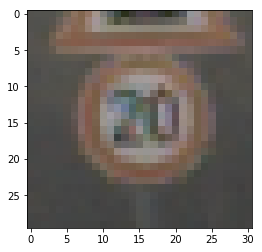

In [8]:
plt.imshow(load_img_id(data.val_ds, 1, path))
plt.show()

In [9]:
y = data.trn_ds.y

In [10]:
print(y[:10])

[0 0 0 0 0 0 0 0 0 0]


In [11]:
from collections import Counter

label_counts = Counter(y).most_common()
for l, c in label_counts:
    print(c, '\t', data.classes[l], '\t', class_names[data.classes[l]])

1800 	 2 	 Speed limit (50km/h)
1776 	 1 	 Speed limit (30km/h)
1728 	 13 	 Yield
1680 	 12 	 Priority road
1656 	 38 	 Keep right
1608 	 10 	 No passing for vechiles over 3.5 metric tons
1584 	 4 	 Speed limit (70km/h)
1488 	 5 	 Speed limit (80km/h)
1200 	 25 	 Road work
1176 	 9 	 No passing
1152 	 7 	 Speed limit (100km/h)
1128 	 3 	 Speed limit (60km/h)
1128 	 8 	 Speed limit (120km/h)
1056 	 11 	 Right-of-way at the next intersection
960 	 18 	 General caution
960 	 35 	 Ahead only
888 	 17 	 No entry
624 	 14 	 Stop
624 	 31 	 Wild animals crossing
552 	 33 	 Turn right ahead
504 	 15 	 No vechiles
480 	 26 	 Traffic signals
432 	 28 	 Children crossing
408 	 23 	 Slippery road
360 	 30 	 Beware of ice/snow
336 	 16 	 Vechiles over 3.5 metric tons prohibited
336 	 34 	 Turn left ahead
336 	 6 	 End of speed limit (80km/h)
312 	 22 	 Bumpy road
312 	 36 	 Go straight or right
288 	 20 	 Dangerous curve to the right
288 	 40 	 Roundabout mandatory
264 	 21 	 Double curve
240 	 39 

0 Speed limit (20km/h)


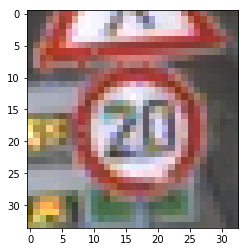

1 Speed limit (30km/h)


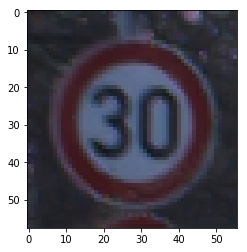

2 Speed limit (50km/h)


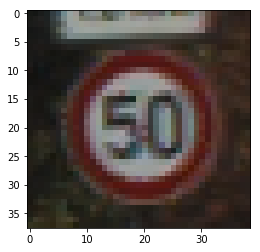

3 Speed limit (60km/h)


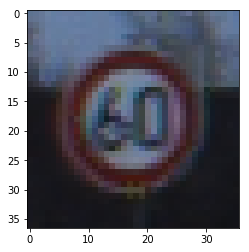

4 Speed limit (70km/h)


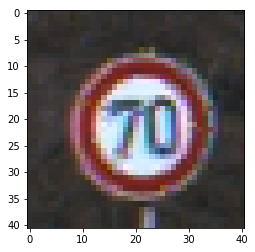

5 Speed limit (80km/h)


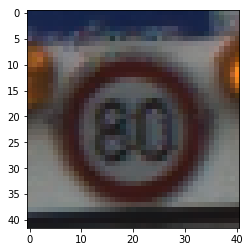

6 End of speed limit (80km/h)


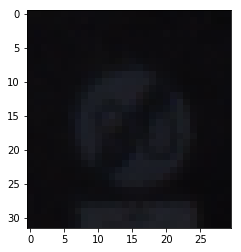

7 Speed limit (100km/h)


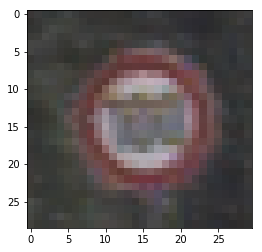

8 Speed limit (120km/h)


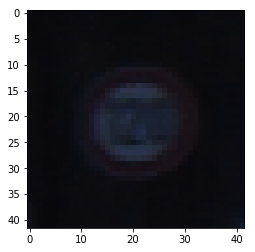

9 No passing


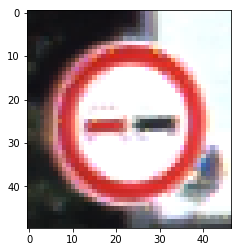

10 No passing for vechiles over 3.5 metric tons


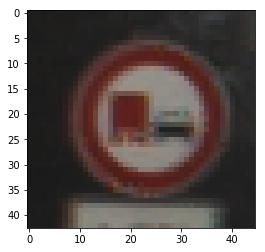

11 Right-of-way at the next intersection


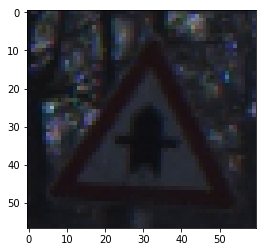

12 Priority road


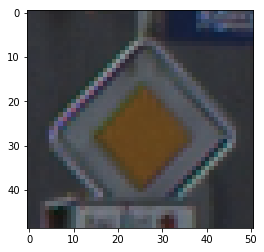

13 Yield


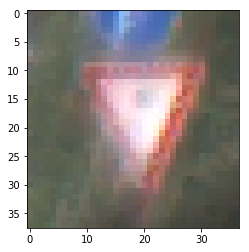

14 Stop


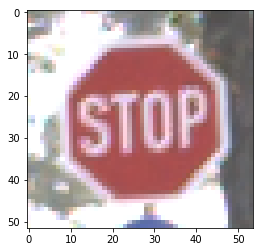

15 No vechiles


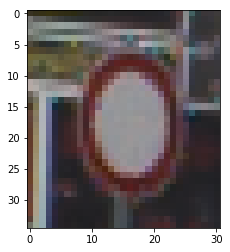

16 Vechiles over 3.5 metric tons prohibited


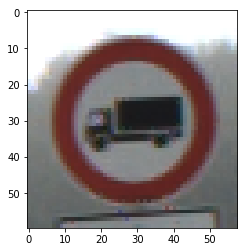

17 No entry


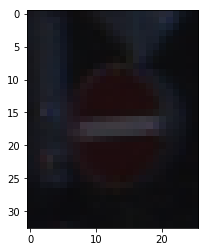

18 General caution


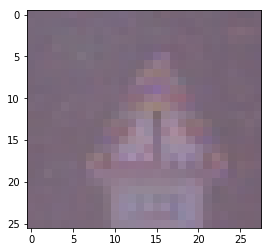

19 Dangerous curve to the left


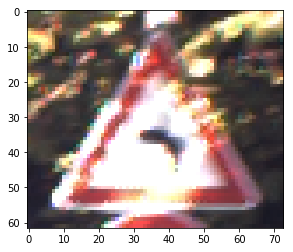

20 Dangerous curve to the right


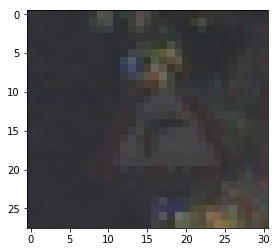

21 Double curve


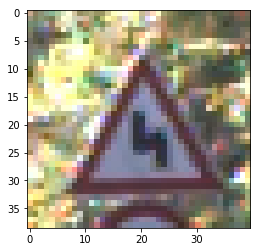

22 Bumpy road


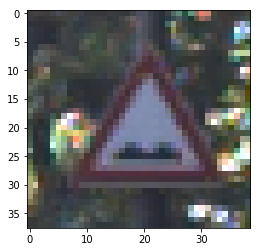

23 Slippery road


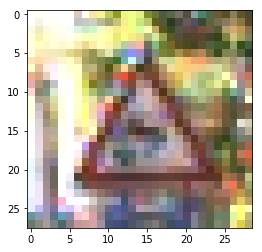

24 Road narrows on the right


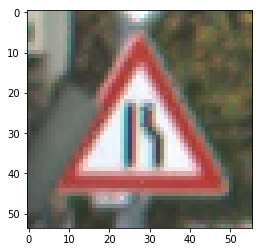

25 Road work


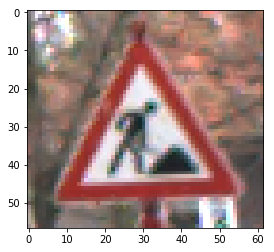

26 Traffic signals


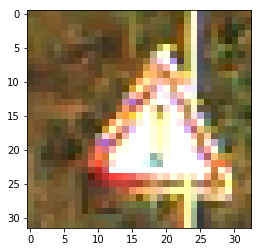

27 Pedestrians


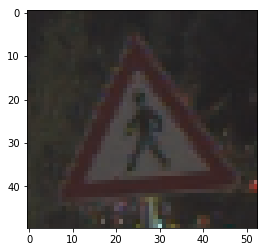

28 Children crossing


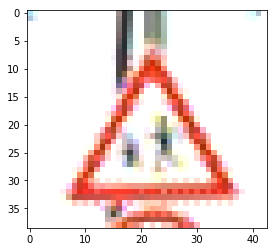

29 Bicycles crossing


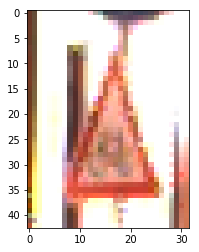

30 Beware of ice/snow


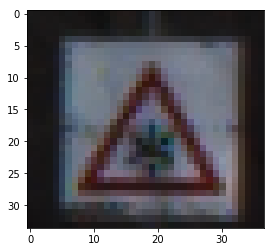

31 Wild animals crossing


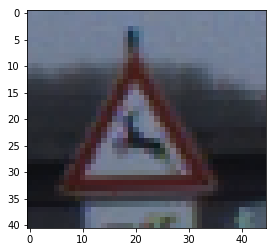

32 End of all speed and passing limits


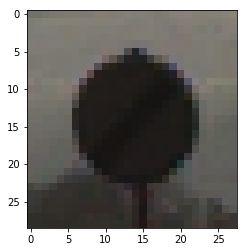

33 Turn right ahead


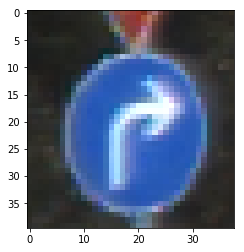

34 Turn left ahead


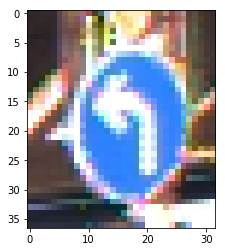

35 Ahead only


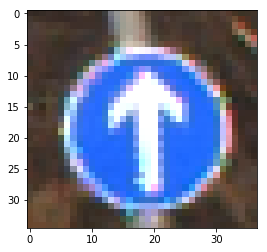

36 Go straight or right


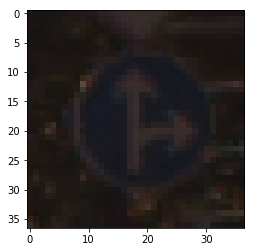

37 Go straight or left


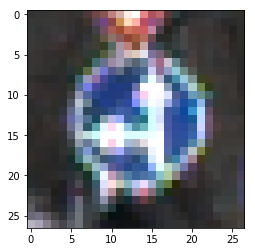

38 Keep right


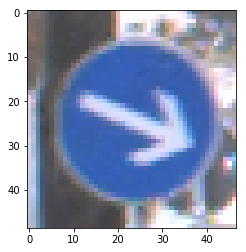

39 Keep left


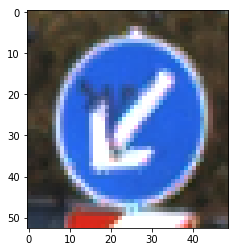

40 Roundabout mandatory


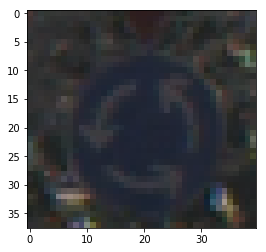

41 End of no passing


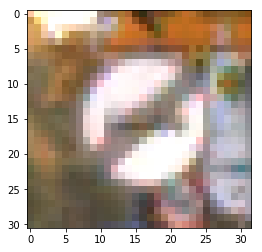

42 End of no passing by vechiles over 3.5 metric tons


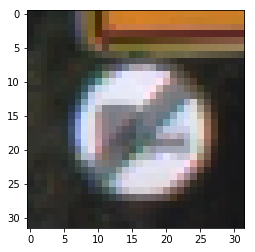

In [12]:
for label in sorted([l for l, c in label_counts], key=lambda p: int(data.classes[p])):
    i = [i for i, l in enumerate(y) if l == label][0]
    print(data.classes[y[i]], class_names[data.classes[y[i]]])
    plt.imshow(load_img_id(data.trn_ds, i, path))
    plt.show()

# Image augmentation

In [13]:
# Look at examples of image augmentation
def get_augs():
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

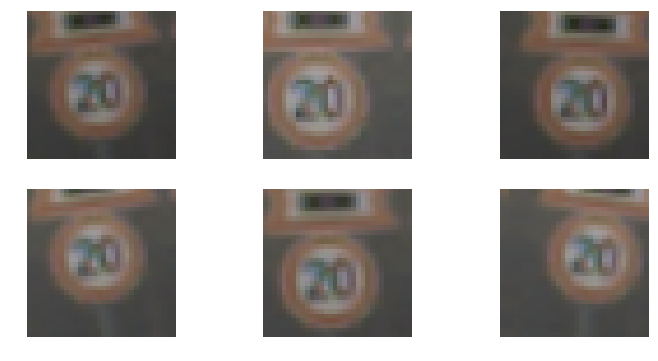

In [14]:
aug_tfms = transforms_basic
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=1.1, pad=sz//8)
data = ImageClassifierData.from_paths(path, tfms=tfms, test_name='test')

ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

# Training

In [15]:
# Create a learner
learn = ConvLearner.pretrained(arch, data, precompute=False)

## Searching for a good starting learning rate

In [16]:
def plot_loss_change(sched, sma=1, n_skip=20, y_lim=(-0.01,0.01)):
    """
    Plots rate of change of the loss function.
    Parameters:
        sched - learning rate scheduler, an instance of LR_Finder class.
        sma - number of batches for simple moving average to smooth out the curve.
        n_skip - number of batches to skip on the left.
        y_lim - limits for the y axis.
    """
    derivatives = [0] * (sma + 1)
    for i in range(1 + sma, len(learn.sched.lrs)):
        derivative = (learn.sched.losses[i] - learn.sched.losses[i - sma]) / sma
        derivatives.append(derivative)
        
    plt.ylabel("d/loss")
    plt.xlabel("learning rate (log scale)")
    plt.plot(learn.sched.lrs[n_skip:], derivatives[n_skip:])
    plt.xscale('log')
    plt.ylim(y_lim)

In [17]:
learn.lr_find()

A Jupyter Widget

 86%|████████▌ | 420/491 [00:11<00:02, 35.23it/s, loss=10.1]

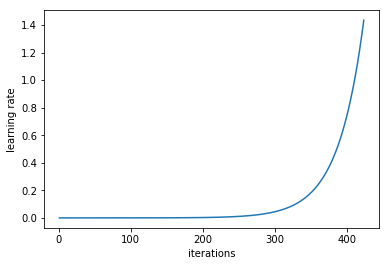

In [18]:
learn.sched.plot_lr()

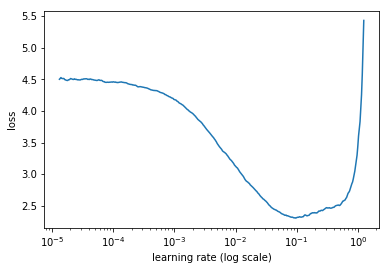

In [19]:
learn.sched.plot()

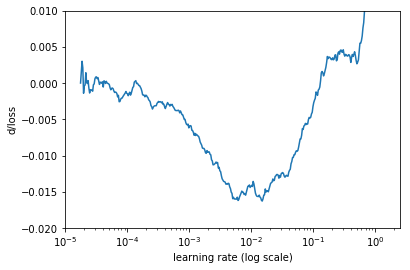

In [20]:
plot_loss_change(learn.sched, sma=20, n_skip=20, y_lim=(-0.02, 0.01))

## Training with LR 0.01 for 3 epochs

In [21]:
learn.fit(0.01, 3)

A Jupyter Widget

 43%|████▎     | 211/491 [00:07<00:09, 29.69it/s, loss=1.89]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/root/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/root/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                   
    0      1.587202   1.234954   0.587918  
    1      1.3931     1.084209   0.635143                   
    2      1.322326   0.994706   0.661528                   



[0.99470639, 0.66152762397518006]

In [22]:
learn.save('1')

A Jupyter Widget

 84%|████████▎ | 411/491 [00:11<00:02, 35.00it/s, loss=5.46]

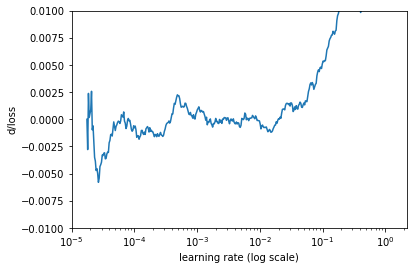

In [23]:
learn.lr_find()
plot_loss_change(learn.sched, sma=20, n_skip=20, y_lim=(-0.01, 0.01))

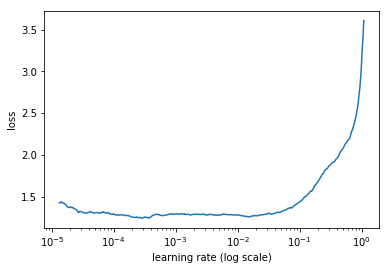

In [24]:
learn.sched.plot()

## 3 iterations with cycling learning rate schedule

In [25]:
learn.fit(1e-2, 3, cycle_len=1)

A Jupyter Widget

 46%|████▌     | 224/491 [00:07<00:09, 29.54it/s, loss=1.27]

Exception in thread Thread-8:
Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/root/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/root/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                   
    0      1.295811   0.923783   0.696827  
    1      1.189568   0.885519   0.712468                   
    2      1.179614   0.868362   0.717152                   



[0.86836189, 0.71715247001105209]

In [26]:
learn.save('2')

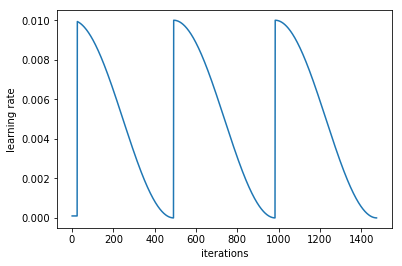

In [27]:
learn.sched.plot_lr()

## Unfreeze lower layers and train with differential learning rates

In [28]:
learn.unfreeze()

In [29]:
lr=np.array([1e-4,1e-3,1e-2])

In [30]:
learn.fit(lr, 5, cycle_len=1, cycle_mult=2)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                   
    0      1.103873   0.869196   0.707864  
    1      0.713018   0.489637   0.835501                    
    2      0.559707   0.393814   0.869045                    
    3      0.478904   0.289493   0.904606                    
    4      0.362211   0.179312   0.940295                    
    5      0.299188   0.141319   0.952236                    
    6      0.269287   0.137522   0.954776                    
    7      0.297138   0.135441   0.956301                    
    8      0.23635    0.138767   0.957444                    
    9      0.220777   0.110399   0.965193                    
    10     0.166591   0.070441   0.977515                    
    11     0.128224   0.146331   0.97345                     
    12     0.13252    0.070621   0.979167                     
    13     0.11807    0.104663   0.97561                      
    14     0.125714   0.060757   0.981707                     
    15     0.162185   0.

[0.15707389, 0.98132621951219512]

In [31]:
learn.save('3')

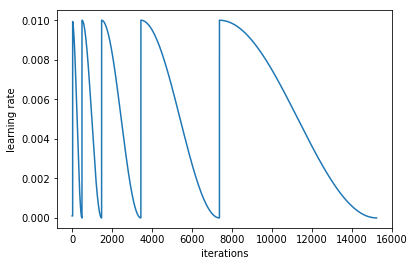

In [32]:
learn.sched.plot_lr()

## Error analysis

In [91]:
log_preds,y = learn.predict_with_targs()
preds = np.exp(log_preds)
pred_labels = np.argmax(preds, axis=1)

In [94]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, pred_labels)

In [95]:
cm

array([[ 42,   0,   0, ...,   0,   0,   0],
       [  1, 439,   0, ...,   0,   0,   0],
       [  0,   1, 400, ...,   0,   0,   1],
       ..., 
       [  0,   0,   0, ..., 231,   3,   0],
       [  0,   0,   0, ...,   1, 232,   0],
       [  0,   0,   0, ...,   0,   0, 294]])

In [96]:
results = ImageModelResults(data.val_ds, log_preds)

### Most incorrect

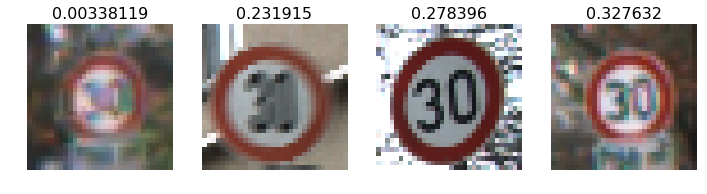

In [101]:
results.plot_most_incorrect(1)

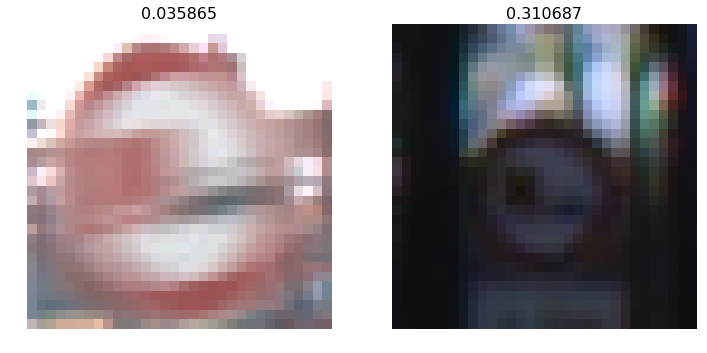

In [102]:
results.plot_most_incorrect(2)

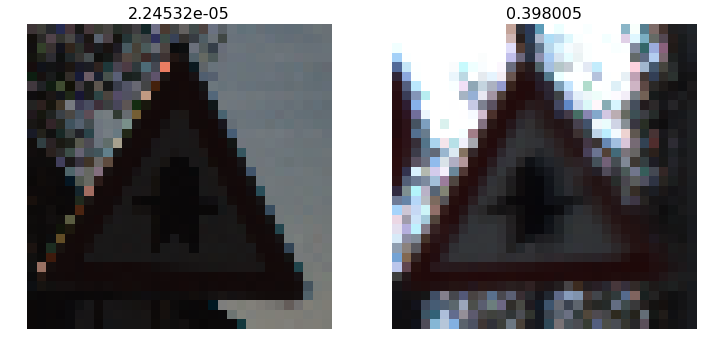

In [103]:
results.plot_most_incorrect(3)

### Most correct

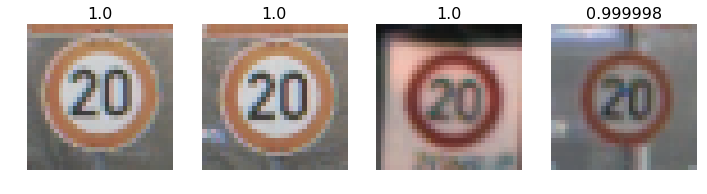

In [104]:
results.plot_most_correct(0)

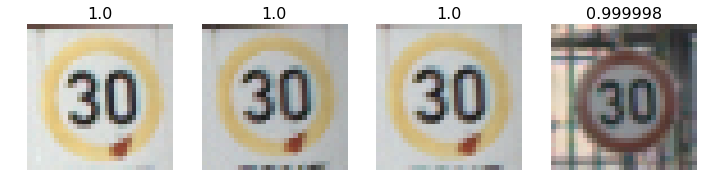

In [107]:
results.plot_most_correct(1)

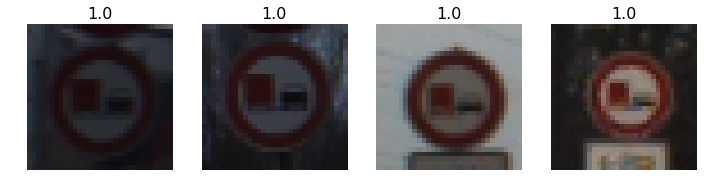

In [108]:
results.plot_most_correct(2)

### Most uncertain

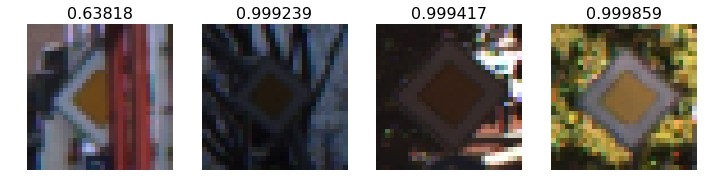

In [115]:
results.plot_most_uncertain(4)

## Test time augmentation (TTA)

In [116]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)

In [117]:
accuracy_np(preds, y)

0.99222038005356461

# Testing on a test set

In [119]:
log_preds,y = learn.TTA(is_test=True)
preds = np.mean(np.exp(log_preds),0)

In [120]:
pred_labels = np.argmax(preds, axis=1)
pred_labels.shape

(12630,)

01154.ppm 10 No passing for vechiles over 3.5 metric tons


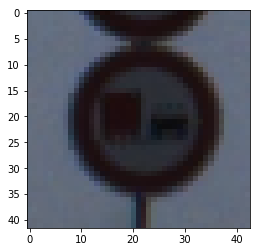

00920.ppm 12 Priority road


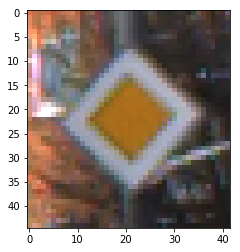

00314.ppm 1 Speed limit (30km/h)


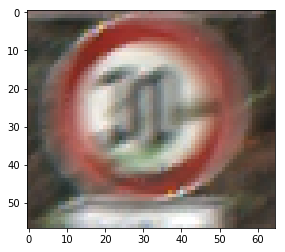

04816.ppm 25 Road work


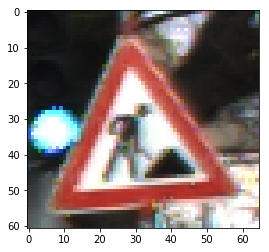

05959.ppm 8 Speed limit (120km/h)


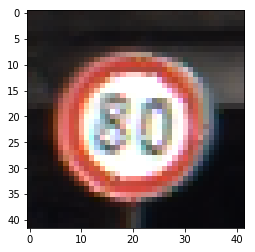

09102.ppm 1 Speed limit (30km/h)


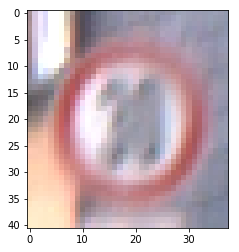

01541.ppm 29 Bicycles crossing


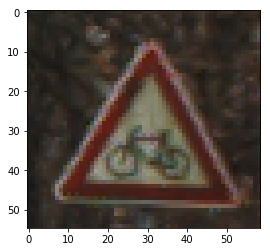

02728.ppm 15 No vechiles


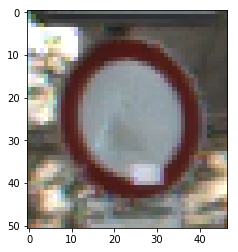

03602.ppm 1 Speed limit (30km/h)


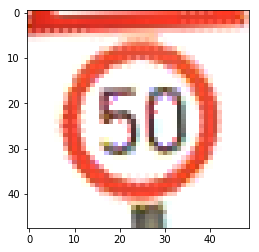

12548.ppm 9 No passing


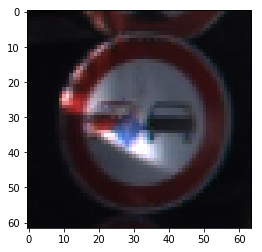

In [121]:
for i in range(10):
    class_id = data.classes[pred_labels[i]]
    filename = data.test_ds.fnames[i].split('/')[1]
    print(filename, class_id, class_names[class_id])
    plt.imshow(load_img_id(data.test_ds, i, path))
    plt.show()

In [122]:
with open('data/submission.csv', 'w') as f:
    for i in range(pred_labels.shape[0]):
        filename = data.test_ds.fnames[i].split('/')[1]
        f.write('{};{}\n'.format(filename, data.classes[pred_labels[i]]))

In [123]:
from IPython.display import FileLink
FileLink('data/submission.csv')

/notebooks/sd/GTSRB/data/submission.csv